In [1]:
!pip install imbalanced-learn
!pip install wordcloud

In [2]:
import os
import json
import gzip
from urllib.request import urlopen
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from nltk.probability import FreqDist
from nltk import ngrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import multiprocessing
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

In [3]:
# Descarga de datos de valoraciones de vehículos en Amazon
!curl -k -O https://jmcauley.ucsd.edu/data/amazon_v2/categoryFiles/Vehicles.json.gz

# Pasamos el archivo JSON en un dataframe con las columnas que nos interesan para el análisis
df = pd.read_json('Vehicles.json.gz', lines=True)
df = pd.DataFrame(df[['overall','reviewText']])
df.shape

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8781k  100 8781k    0     0  9868k      0 --:--:-- --:--:-- --:--:-- 9867k


(60559, 2)

5    43610
4    11300
3     2783
1     1716
2     1150
Name: overall, dtype: int64


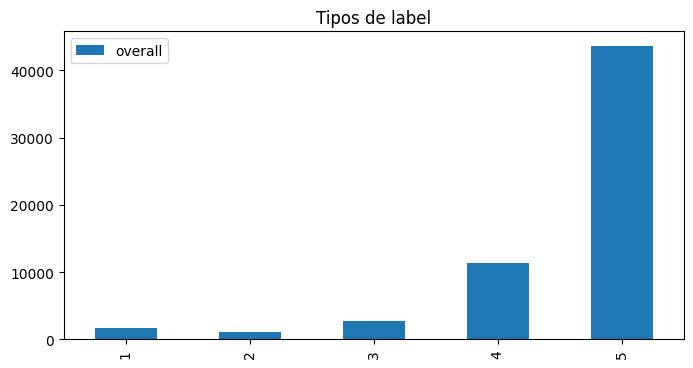

In [4]:
# Existe un claro desbalanceamiento de las etiquetas
aux_df = pd.DataFrame(df['overall'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Tipos de label', figsize=(8, 4))

# Distribución de reviews por número de estrellas
conteos_valores = df['overall'].value_counts()
print(conteos_valores)

In [5]:
# Verificar la cantidad de valores nulos en cada columna
nulos_por_columna = df.isna().sum()
print('Nulos antes de eliminarlos')
print('\n', nulos_por_columna)

# Quitamos los nulos o los vacíos
df = df.replace('', np.nan)
df = df.dropna()
df.shape

# Verificar que ya no existan nulos
nulos_por_columna = df.isna().sum()
print('\n Verificamos que no haya nulos después de eliminarlos')
print('\n', nulos_por_columna)

Nulos antes de eliminarlos

 overall         0
reviewText    498
dtype: int64

 Verificamos que no haya nulos después de eliminarlos

 overall       0
reviewText    0
dtype: int64


In [6]:
# Vamos a realizar undersampling para que todas las etiquetas tengan la misma cantidad de valores
X = df['reviewText']
y = df['overall']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X.values.reshape(-1, 1), y)

# Crear un nuevo DataFrame con los datos undersampled
df = pd.DataFrame({'reviewText': X_resampled.flatten(), 'overall': y_resampled})

# Verificar los conteos de clases
conteos_valores_resampled = df['overall'].value_counts()
print(conteos_valores_resampled)

1    1149
2    1149
3    1149
4    1149
5    1149
Name: overall, dtype: int64


In [7]:
# Establecer como positivas o negativas los tipos de label, excluyendo del proceso a 'label = 3' (lo consideramos neutro)
df = df[df['overall'] != 3]

# Positivizamos(4, 5) y negativizamos (1, 2) los tipos de label
df['overall'] = df['overall'].replace({1: 0, 2: 0, 4: 1, 5: 1})

# Mostramos número de reviews positivas y negativas
conteos_valores = df['overall'].value_counts()
print(conteos_valores)

0    2298
1    2298
Name: overall, dtype: int64


In [8]:
# Cardinalidad del vocabulario
splitted_reviews = df['reviewText'].str.split()
words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)

vocabulary_ = Counter(words)
len(vocabulary_)

25487

In [9]:
# Ngram más frecuentes
# Las palabras más frecuentes son preposiciones que quitaremos con la función de stop words
onegrams_ = ngrams(words, 1)
onegrams_freq_ = FreqDist(onegrams_)
print('\n ngrams de 1 palabra', onegrams_freq_.most_common(10))

twograms_ = ngrams(words, 2)
twograms_freq_ = FreqDist(twograms_)
print('\n ngrams de 2 palabras', twograms_freq_.most_common(10))

threegrams_ = ngrams(words, 3)
threegrams_freq_ = FreqDist(threegrams_)
print('\n ngrams de 3 palabras', threegrams_freq_.most_common(10))


 ngrams de 1 palabra [(('the',), 12222), (('and',), 7665), (('a',), 6874), (('to',), 6437), (('I',), 6108), (('it',), 4351), (('is',), 3904), (('of',), 3581), (('in',), 2843), (('for',), 2640)]

 ngrams de 2 palabras [(('I', 'have'), 961), (('of', 'the'), 842), (('in', 'the'), 833), (('on', 'the'), 662), (('and', 'the'), 559), (('to', 'the'), 504), (('is', 'a'), 488), (('with', 'the'), 474), (('for', 'the'), 460), (('the', 'car'), 443)]

 ngrams de 3 palabras [(('a', 'lot', 'of'), 172), (('I', 'have', 'had'), 123), (('I', 'have', 'ever'), 116), (('miles', 'on', 'it'), 114), (('to', 'replace', 'the'), 114), (('I', 'had', 'to'), 107), (('had', 'to', 'replace'), 91), (('I', 'have', 'a'), 85), (('had', 'to', 'be'), 74), (('miles', 'on', 'it.'), 69)]


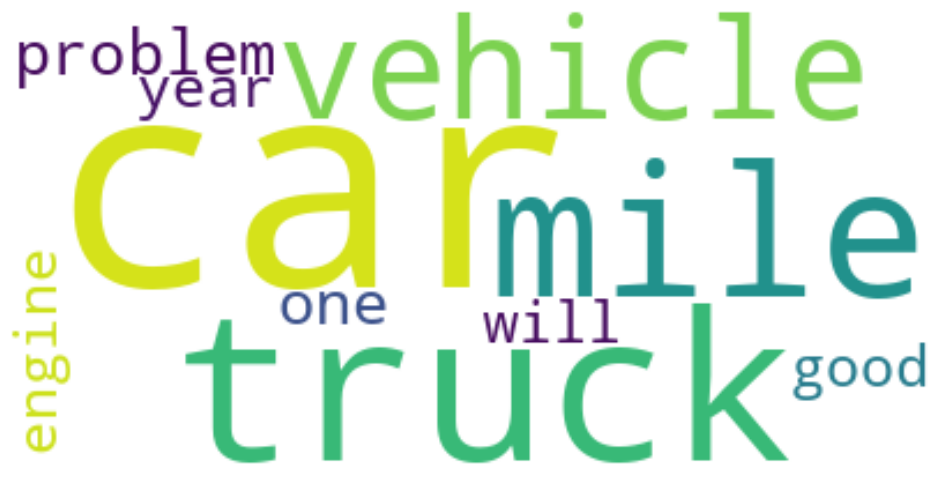

In [10]:
# Creamos WordCloud para ver las palabras que más se repiten
text_data = ' '.join(df['reviewText'])
wordcloud = WordCloud(max_words=10, background_color='white').generate(text_data)

# Mostrar la nube de palabras
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
# Word2Vec para ver las palabras más similares
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20
                    )

sent = [row.split() for row in df['reviewText']]
w2v_model.build_vocab(sent)

print('Vocabulario compuesto por {} palabras'.format(len(w2v_model.wv.index_to_key)))

w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

w2v_model.wv.most_similar(positive=["car", "vehicle", "truck", "problem"])

Vocabulario compuesto por 1481 palabras


[('worse', 0.9736672043800354),
 ('life', 0.967747151851654),
 ('choice', 0.9615288376808167),
 ('This', 0.9608029723167419),
 ('2000', 0.9592465162277222),
 ('Subaru', 0.9531522393226624),
 ('own.', 0.9505223035812378),
 ('Chevy', 0.9497703909873962),
 ('S', 0.9492467045783997),
 ('junk', 0.9476124048233032)]

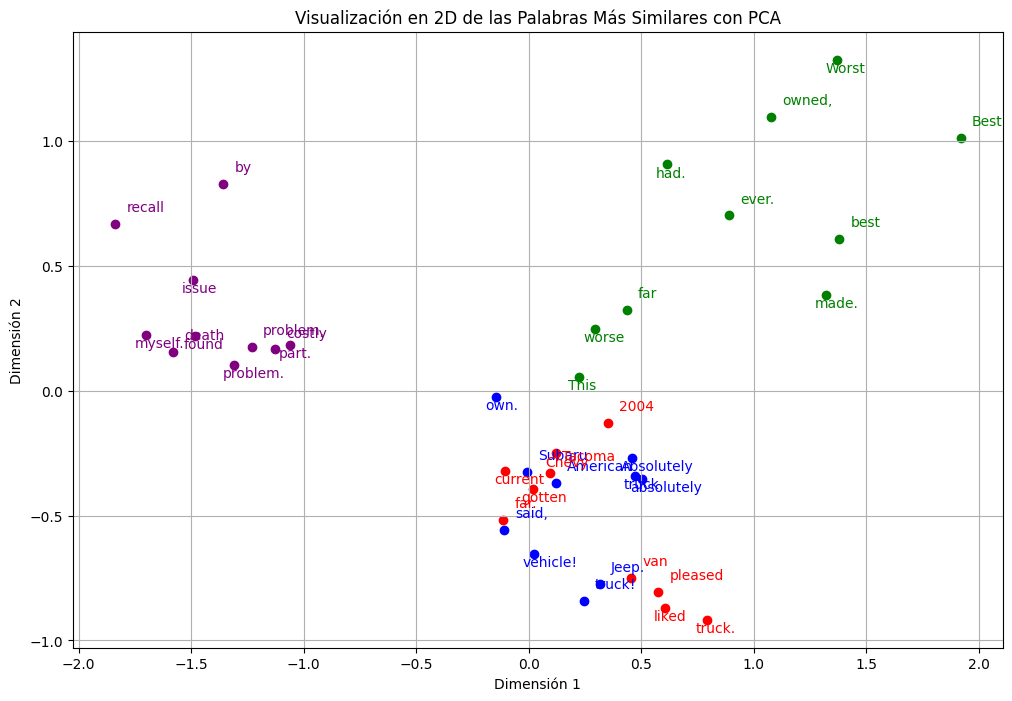

In [12]:
# Palabras para las que deseas encontrar palabras similares
palabras_similares = ["car", "vehicle", "truck", "problem"]

# Obtener las palabras más similares
palabras_similares_dict = {}
for palabra in palabras_similares:
    similares = w2v_model.wv.most_similar(positive=[palabra], topn=10)
    palabras_similares_dict[palabra] = [sim[0] for sim in similares]

# Obtener los vectores de las palabras más similares
vectores_similares = [w2v_model.wv[palabra] for palabras in palabras_similares_dict.values() for palabra in palabras]

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
vectores_reducidos = pca.fit_transform(vectores_similares)

# Crear un gráfico de dispersión en 2D
plt.figure(figsize=(12, 8))

# Colores para cada conjunto de palabras similares
colores = ['blue', 'green', 'red', 'purple']

# Etiquetar las palabras más similares con colores
for i, palabras in enumerate(palabras_similares_dict.values()):
    color = colores[i]
    for j, palabra in enumerate(palabras):
        offset = 0.05 if j % 2 == 0 else -0.05  # Aumenta el valor del offset

        plt.scatter(vectores_reducidos[i*10+j, 0], vectores_reducidos[i*10+j, 1], marker='o', color=color)
        plt.annotate(palabra, xy=(vectores_reducidos[i*10+j, 0], vectores_reducidos[i*10+j, 1]),
                     fontsize=10, xytext=(vectores_reducidos[i*10+j, 0] + offset, vectores_reducidos[i*10+j, 1] + offset), color=color)

plt.title('Visualización en 2D de las Palabras Más Similares con PCA')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.grid()
plt.show()

In [13]:
# Guardamos el dataframe para su posterior preprocesamiento
df.to_csv('df_vehicles.csv', index=False)

# Conclusiones
""" A pesar de ser un análisis exploratorio veo necesario desde el principio realizar
    transformaciones, tales como escoger las columnas de interés, eliminación de nulos
    o realización de undersampling para una mejor exploración de los datos """

' A pesar de ser un análisis exploratorio veo necesario desde el principio realizar\n    transformaciones, tales como escoger las columnas de interés, eliminación de nulos\n    o realización de undersampling para una mejor exploración de los datos '